# Simple model workflow

This notebook creates a simple model on solar data with one regressor. This fitted model is then evaluated.

In [1]:
## import packages
import pandas as pd
import importlib
from datetime import datetime, timedelta

%matplotlib inline

In [2]:
## import custom modules
from ts_forecasting import speccing, modelling, featuring

/home/nicolas/anaconda3/envs/forecasting-venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# useful for relaoding after changes were made to the code
importlib.reload(speccing)
importlib.reload(modelling)
importlib.reload(featuring)

<module 'ts_forecasting.featuring' from '/home/nicolas/workspace/seita/load-forecasting/ts_forecasting/featuring.py'>

## Describing the model

In [4]:
PATH_TO_DATA = '../data/pickles'
modelling.MODEL_DIR = "../models"

start = datetime(2015, 4, 13, 1, 45)
outcome_var_spec = speccing.DFFileSeriesSpecs("%s/df_ss_pv_res15T.pickle" % PATH_TO_DATA,
                                            column="y", name="solar_production")

def day_lags(lags):
    return  [l * 96 for l in lags]


def make_forecast_for_now(df: pd.DataFrame) -> pd.DataFrame:
    """Generate a variable for 'forecast' of radiation at time t.
    Basically the actual value of t+2 is viewed as the prediction at t of day t+2.
    Therefore, there is no function for this, as this is 'faked' data.
    """
    # First rename to an initial name, we'll return to this name eventually
    df.rename(columns={'radiation_forecast_2days_l2': 'radiation'}, inplace=True)
    featuring.add_lags(df, 'radiation', day_lags([2]), name_as="day", inplace=True)
    df.rename(columns={'radiation_f2': 'radiation_forecast_2days'}, inplace=True)
    featuring.add_lags(df, 'radiation_forecast_2days', day_lags([-2]), name_as="day", inplace=True)
    return df
    
    
regressor_specs = [speccing.DFFileSeriesSpecs("%s/df_total_radiation_res15T.pickle" % PATH_TO_DATA,
                                            column="y", name="radiation_forecast_2days_l2")
                  ]


specs = modelling.ModelSpecs(outcome_var=outcome_var_spec,
                             model_type="OLS",
                             lags=day_lags([-2,-3,-4,-5,-6,-7]),
                             regressors=regressor_specs,
                             start_of_data=start,
                             end_of_data=start + timedelta(days=32),
                             ratio_training_test_data=14 / 15,
                             horizons=["6H", "48H"],
                             transform=make_forecast_for_now)


# INCLUDE_CONSTANT = True  # TODO

print(specs)

ModelSpecs: <{'creation_time': datetime.datetime(2018, 4, 19, 17, 34, 27, 409515),
 'end_of_data': datetime.datetime(2015, 5, 15, 1, 45),
 'horizons': ['6H', '48H'],
 'lags': [-192, -288, -384, -480, -576, -672],
 'model_filename': None,
 'model_type': 'OLS',
 'outcome_var': DFFileSeriesSpecs: <{'column': 'y', 'name': 'solar_production', 'file_path': '../data/pickles/df_ss_pv_res15T.pickle'}>,
 'ratio_training_test_data': 0.9333333333333333,
 'regressors': [DFFileSeriesSpecs: <{'column': 'y', 'name': 'radiation_forecast_2days_l2', 'file_path': '../data/pickles/df_total_radiation_res15T.pickle'}>],
 'remodel_frequency': datetime.timedelta(1),
 'start_of_data': datetime.datetime(2015, 4, 13, 1, 45),
 'transform': <function make_forecast_for_now at 0x7f9de4378268>}>


## Creating and training the model

In [5]:
model = modelling.create_model(specs, "0.1")

Start of training: 2015-04-13 01:45:00
End of training: 2015-05-12 22:30:00
Index(['const', 'solar_production', 'radiation'], dtype='object')
Index(['const', 'solar_production', 'radiation', 'radiation_f2'], dtype='object')
Index(['const', 'solar_production', 'radiation', 'radiation_forecast_2days'], dtype='object')


## Evaluating the model

In [6]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     2331.
Date:                Thu, 19 Apr 2018   Prob (F-statistic):               0.00
Time:                        17:34:27   Log-Likelihood:                -3909.8
No. Observations:                2868   AIC:                             7834.
Df Residuals:                    2861   BIC:                             7875.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
solar_production_l192           0.2127      0.020     10.422      0.000       0.173       0.253
solar_production_l288          -0.0264      0.020     -1.305      0.192      -0.066       0.013
solar_production_l384          -0.0153      0.018     -0.830      0.407      -0.051       0.021
solar_production_l480           0.3211      0.018     17.362      0.000       0.285       0.357
solar_production_l576           0.1748      0.018      9.657      0.000       0.139       0.210
solar_production_l672           0.2488      0.019     13.275      0.000       0.212       0.286
radiation_forecast_2days_l2     0.9231      0.136      6.786      0.000       0.656       1.190
==============================================================================
Omnibus:                      260.571   Durbin-Watson:                   0.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1410.339
Skew:                          -0.244   Prob(JB):                    5.61e-307
Kurtosis:                       6.401   Cond. No.                         40.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Start of testing: 2015-05-12 22:45:00
End of testing: 2015-05-15 01:45:00
Index(['const', 'solar_production', 'radiation'], dtype='object')
Index(['const', 'solar_production', 'radiation', 'radiation_f2'], dtype='object')
Index(['const', 'solar_production', 'radiation', 'radiation_forecast_2days'], dtype='object')
rmse = 1.1852


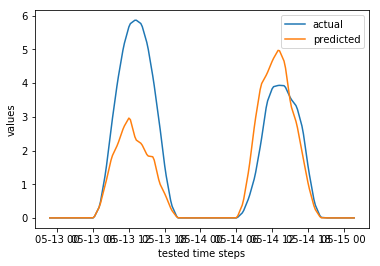

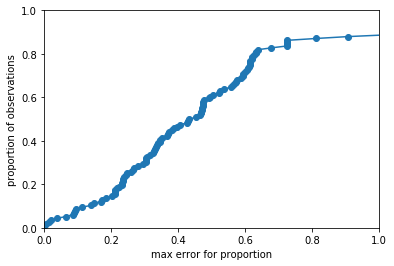

In [7]:
modelling.evaluate_models(m1=(model, specs))